# Def /////////////////////////////////////////////////

In [1]:
import numpy as np
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain, zip_longest
import random
import time
import math
import wave
import struct

# image

In [2]:
def divide1d(lst, group_num):
    lstlen = len(lst)
    quotient = int(lstlen/group_num)
    rst = lstlen%group_num
    if rst == 0 :
        dividedlist = list(zip(*[iter(lst)]*quotient))
    elif rst > 0 :
        dividedlist = list(zip(*[iter(lst)]*(quotient+1)))
        dividedlist = dividedlist[0:rst]
        rstlst = range(dividedlist[-1][-1]+1, lstlen)
        dividedlist.extend( list(zip(*[iter(rstlst)]*(quotient))) )
    
    for i in range(len(dividedlist)):
        dividedlist[i] = list(dividedlist[i])

    return(dividedlist)


def divideimage(img, divw, divh):
    height, width, channels = img.shape
    heights =  divide1d(range(height), divh)
    widths =  divide1d(range(width), divw)
    
    imgF = np.float_(img)

    dividedimgs = []
    for ih in range(0,divh,1):
        temp = []
        for iw in range(0,divw,1):
            temp.append( imgF[heights[ih][0]:heights[ih][-1], widths[iw][0]:widths[iw][-1]] )
        dividedimgs.append( temp )
    
    return(heights, widths, dividedimgs)


def mean_image(img):
    flattened_img = np.array(list(chain.from_iterable(img)))
    mean_img =  sum(flattened_img)/len(flattened_img)
    return(mean_img)


def hsv2rgb(h, s, v):
    h = float(h)
    s = float(s)
    v = float(v)
    h60 = h / 60.0
    h60f = math.floor(h60)
    hi = int(h60f) % 6
    f = h60 - h60f
    p = v * (1 - s)
    q = v * (1 - f * s)
    t = v * (1 - (1 - f) * s)
    r, g, b = 0, 0, 0
    if hi == 0: r, g, b = v, t, p
    elif hi == 1: r, g, b = q, v, p
    elif hi == 2: r, g, b = p, v, t
    elif hi == 3: r, g, b = p, q, v
    elif hi == 4: r, g, b = t, p, v
    elif hi == 5: r, g, b = v, p, q
    r, g, b = int(r * 255), int(g * 255), int(b * 255)
    return r, g, b
    
def rgb2hsv(r, g, b):
    r, g, b = r/255.0, g/255.0, b/255.0
    mx = max(r, g, b)
    mn = min(r, g, b)
    df = mx-mn
    if mx == mn:
        h = 0
    elif mx == r:
        h = (60 * ((g-b)/df) + 360) % 360
    elif mx == g:
        h = (60 * ((b-r)/df) + 120) % 360
    elif mx == b:
        h = (60 * ((r-g)/df) + 240) % 360
    if mx == 0:
        s = 0
    else:
        s = df/mx
    v = mx
    return h, s, v

# R, G, B values are [0, 255]. H value is [0, 360]. S, V values are [0, 1].

# music

In [3]:
def makewave(amp,freq,sec,sr):
    outwave = []
    for i in range( int(sec*sr) ) :
        w = amp*np.sin(2*np.pi*freq*i/sr)
        outwave.append(w)
    return(outwave)


def wavwrite(inputlist,filename):
    maxamp = 32767.0
    int16wave = [int(x * maxamp) for x in inputlist]
    binwave = struct.pack("h"*len(int16wave),*int16wave)

    nchannnles = 1 # 1=monoral , 2=stereo
    sampwitdth = 2 # 1=8bit,2=16bit,3=,...
    framerate = 44100 # sampling rate ex.44100Hz
    nframes = len(inputlist) # framerate * sec
    
    of = wave.open(filename,"w")
    of.setparams((nchannnles,sampwitdth,framerate,nframes,"NONE","not compressed"))
    of.writeframes(binwave)
    of.close
    
    
# amp
def ampFn(amp_type,t,t0,T,amp,aparam):
    # t0: initial time
    # T: length of time for sound
    # t1: time of peak
    # a1: trancation exponent(a1=1: NoEffect, 1<<a1: too tracate)
    # a2: trancation exponent(0<a2, 0<a2<<1: too tracate, 1<<a2: NoEffect
    # a1=-1&a2=1: convex trancation shape
    t1 = aparam[0]
    a1 = aparam[1]
    a2 = aparam[2]
    if amp_type == 1:
        if t <= t0:
            ampVal = 0
        else:
            if t <= t0 + t1:
                ampVal = amp*(t-t0)/t1
            else:
                ampVal = amp*(-(t-T)/T)*((t1+a2)/(t-t0+a2))**a1
    elif amp_type == 2:
        if t <= t0:
            ampVal = 0
        else:
            ampVal = amp*(1-(t-t0)/T)**2
    elif amp_type == 3:
        if t <= t0:
            ampVal = 0
        else:
            ampVal = amp*(1-((t-t0)/T)**(1/10))


    return(ampVal)


def waveFn(wave_type,t,t1,param,freq):
    if   wave_type == 1:
        #Sin Wave
        wave = np.sin(2*np.pi * freq*t)
    elif wave_type == 2:
        #Sawtooth Wave
        wave = 2*((t-t1)*freq - np.floor((t-t1)*freq + 0.5))
    elif wave_type == 3:
        #Triangle Wave
        wave = 2*abs(2*((t-t1+1/(4*freq))*freq - np.floor((t-t1+1/(4*freq))*freq + 0.5)))-1
    elif wave_type == 4:
        #Square Wave
        wave = np.sign(np.sin(2*np.pi * freq*t))
    elif wave_type == 5:
        #Pulse Wave 1
        wave = np.sign(- (t-t1)*freq + np.floor((t-t1)*freq) + param[0])
    return(wave)



#def makeampFnwave(amp, freq, T, dT, sr, aparam):
def makeampFnwave(amp, freq, T, sr, aparam):
    outwave = []
#    T = np.around(T/dT)*dT
    dt = 1/sr
    t0 = 0
    for t in np.arange( 0., T+dt, dt ) :
#        w = ampFn(1, t, t0, T, amp, aparam)*np.sin(2*np.pi*freq*t)
#        w = ampFn(2, t, t0, T, amp, aparam)*np.sin(2*np.pi*freq*t)
#        w = ampFn(1, t, t0, T, amp, aparam) * ( waveFn(1, t, 0, 1, freq) + waveFn(1, t, 0, 1, 2*freq)/4 + waveFn(1, t, 0, 1, 3*freq)/6 + waveFn(1, t, 0, 1, 4*freq)/8 )
        w = ampFn(2, t, t0, T, amp, aparam) * ( waveFn(1, t, 0, 1, freq) + waveFn(1, t, 0, 1, 2*freq)/4 + waveFn(1, t, 0, 1, 3*freq)/6 + waveFn(1, t, 0, 1, 4*freq)/8 )
#        w = ampFn(3, t, t0, T, amp, aparam) * ( waveFn(1, t, 0, 1, freq) + waveFn(1, t, 0, 1, 2*freq)/4 + waveFn(1, t, 0, 1, 3*freq)/6 + waveFn(1, t, 0, 1, 4*freq)/8 )
        outwave.append(w)
    return(outwave)



def value2key(initial_octave, plus_octave, initial_key, values):
    value, valuemin, valuemax = values
    dvalue = valuemax-valuemin
    keymin = 12*initial_octave + initial_key
    keymax = 12*(initial_octave + plus_octave) + initial_key
    dkey = keymax - keymin

    key = int( keymin + dkey * (value-valuemin)/(valuemax-valuemin) )
    freq = 16.35 * (( math.pow(2.0, key) ) ** (1.0/12.0))
    
    return(freq)


def value2keywb(initial_octave, plus_octave, initial_key, values, wbs):
    value, valuemin, valuemax = values
    dvalue = valuemax-valuemin
    wb, allwhites, allblacks = wbs  # wb=1=white_key, wb=0=black_key

    dvalue = valuemax-valuemin
    if(wb == 1):
        octave_num = 7
        allwbs = allwhites
    elif(wb == 0):
        octave_num = 5
        allwbs = allblacks
        
    keymin = octave_num*initial_octave + initial_key
    keymax = octave_num*(initial_octave + plus_octave) + initial_key
    dkey = keymax - keymin

    key = allwbs[ int( keymin + dkey * (value-valuemin)/(valuemax-valuemin) ) - 0 ]
    freq = 16.35 * (( math.pow(2.0, key) ) ** (1.0/12.0))

    return(freq)

In [4]:
def merge1d(lst0, lst1):
    len0 = len(lst0)
    len1 = len(lst1)
    aft0 = max([len0, len1])-len0
    aft1 = max([len0, len1])-len1
    mergedlst = np.lib.pad(lst0,(0, aft0),"constant",constant_values = 0) + np.lib.pad(lst1,(0, aft1),"constant",constant_values = 0)
    return(mergedlst)

# Main ///////////////////////////////////////////////////////////

In [5]:
start_whole_time = time.time()

blackbase=[  1,3,   6, 8, 10]
whitebase=[0,2,4,5,7,9,11]
whites = []
blacks = []
for i in range(0, 10):
    whites.append( np.array(whitebase)+12*i )
    blacks.append( np.array(blackbase)+12*i )
allwhites = list( np.concatenate(whites) )
allblacks = list( np.concatenate(blacks) )
#print(allwhites)
#print(allblacks)

# image

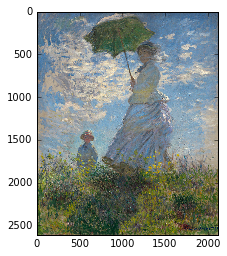

In [6]:
#img = cv2.imread("../../_fig/_others/miporin.jpg")
img = cv2.imread("../../_fig/monet/woman_withparasol.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
height, width, channels = img.shape
plt.imshow(img)

## melody part  --------------------------------------

In [7]:
divw = 50
divh = 50
icodemax = 200
heights, widths, dividedimgs = divideimage(img, divw, divh)
#print(dividedimgs.shape)
#dividedimgs

In [8]:
decolorRGBs = []
decolorHSVs = []
for iw in range(divw):
    tempRGB = []
    tempHSV = []
    for ih in range(divh):
#        meanRGB = mean_image(dividedimgs[ih,iw])
#        print(dividedimgs[ih][iw])
        meanRGB = mean_image(dividedimgs[ih][iw])
#        print(meanRGB)
        tempRGB.append( meanRGB )
        tempHSV.append( rgb2hsv(meanRGB[0],meanRGB[1],meanRGB[2]) )
    decolorRGBs.append(tempRGB)
    decolorHSVs.append(tempHSV)
decolorRGBs = np.array(decolorRGBs)
decolorHSVs = np.array(decolorHSVs)

print(decolorRGBs.shape)

(50, 50, 3)


In [9]:
codesRGBF = []
codesHSVF = []
codes = []
icode = 0
iw = int(divw/2)
ih = int(divh/2)
codesRGBF.append( decolorRGBs[iw,ih] )
codesRGBF = np.array(codesRGBF)
#print(codesRGBF)

codesHSVF.append( decolorHSVs[iw,ih] )
codesHSVF = np.array(codesHSVF)
#print(codesHSVF)

#icode0 = 0
diw = 1
dih = 1
iwhssetall = []
icheckth = 1
for iih in range(divh):
    for iiw in range(divw):
        iwhssetall.append(str(iiw)+","+str(iih))
         
iwhsset = set([])
iwhs = []
ilogs = []
iwhs.append([iw,ih])
ilogs.append([0,9,iw,ih])
print("[icode, inextposition, iw,ih]", ilogs[0])
inextpositions = []
icheck = 0
#for ii in range(icodemax):
while (len(iwhsset) != len(iwhssetall)) and (icode < icodemax) :
    icode = icode + 1
                
    nextsRGBF = []
    nextsHSVF = []
    inextpositionBoundaries =[]
    iBoundaries = [0,0,0,0]
    if(iw+diw <= divw-1):
        nextsRGBF.append( decolorRGBs[iw+diw,ih] )
        nextsHSVF.append( decolorHSVs[iw+diw,ih] )
    else:
        if(iw < divw-1):
            nextsRGBF.append( decolorRGBs[divw-1,ih] )
            nextsHSVF.append( decolorHSVs[divw-1,ih] )
            iBoundaries[0] = 1
        else:
            nextsRGBF.append( np.array([random.random(),random.random(),random.random()]) )
            nextsHSVF.append( [random.random(),random.random(),random.random()] )
            inextpositionBoundaries.append(0)

    if(iw-diw >= 0):
        nextsRGBF.append( decolorRGBs[iw-diw,ih] )
        nextsHSVF.append( decolorHSVs[iw-diw,ih] )
    else:
        if(iw > 0):
            nextsRGBF.append( decolorRGBs[0,ih] )
            nextsHSVF.append( decolorHSVs[0,ih] )
            iBoundaries[1] = 1
        else:
            nextsRGBF.append( np.array([random.random(),random.random(),random.random()]) )
            inextpositionBoundaries.append(1)
            nextsHSVF.append( [random.random(),random.random(),random.random()] )

    if(ih+dih <= divh-1):
        nextsRGBF.append( decolorRGBs[iw,ih+dih] )
        nextsHSVF.append( decolorHSVs[iw,ih+dih] )
    else:
        if(ih < divh-1):
            nextsRGBF.append( decolorRGBs[iw,divh-1] )
            nextsHSVF.append( decolorHSVs[iw,divh-1] )
            iBoundaries[2] = 1
        else:
            nextsRGBF.append( np.array([random.random(),random.random(),random.random()]) )
            inextpositionBoundaries.append(2)
            nextsHSVF.append( [random.random(),random.random(),random.random()] )

    if(ih-dih >= 0):
        nextsRGBF.append( decolorRGBs[iw,ih-dih] )
        nextsHSVF.append( decolorHSVs[iw,ih-dih] )
    else:
        if(ih > 0):
            nextsRGBF.append( decolorRGBs[iw,0] )
            nextsHSVF.append( decolorHSVs[iw,0] )
            iBoundaries[3] = 1
        else:
            nextsRGBF.append( np.array([random.random(),random.random(),random.random()]) )
            inextpositionBoundaries.append(3)
            nextsHSVF.append( [random.random(),random.random(),random.random()] )
            #print("hello3c")

    nextsHSVF = np.array(nextsHSVF)
    nextsRGBF = np.array(nextsRGBF)

    nextsHF = nextsHSVF[:,0]
    dHues = abs( nextsHF - codesHSVF[icode-1,0] )
    
    dHuesSort = np.sort(dHues)
    dHuesSort

    dHuesindex = []
    for i in range(len(dHues)):
        dHuesindex.append( dHues.tolist().index(dHuesSort[i]) )

    dHuesindexbad = set([])
    if( icode > 1 ):
        if( inextpositionold != 9 ):
            dHuesindexbad.add( dHuesindex.index(inextpositionold) )
    if(len(inextpositionBoundaries) > 0):
        for i in range(len(inextpositionBoundaries)):
            if( icode > 1 ):
                if( inextpositionold != 9 ):
                    if( dHuesindex.index(inextpositionold) != dHuesindex.index(inextpositionBoundaries[i]) ):
                        dHuesindexbad.add( dHuesindex.index(inextpositionBoundaries[i]) )
    dHuesindexbad = list(dHuesindexbad)

    dHuesindexbad = sorted(dHuesindexbad, reverse=True)

    if( len(dHuesindexbad) > 0 ):
        for i in range( len(dHuesindexbad) ):
            dHuesindex.pop( dHuesindexbad[i] )

    inextposition = dHuesindex[0]   #close color
#    inextposition = dHuesindex[ len(dHuesindex)-1 ]   #different color
#    inextposition = dHuesindex[ random.randint(0,len(dHuesindex)-1) ]
    inextpositions.append(inextposition)

    codesRGBF = np.concatenate(np.array([codesRGBF, [nextsRGBF[inextposition]] ]))
    codesHSVF = np.concatenate(np.array([codesHSVF, [nextsHSVF[inextposition]] ]))

    if(inextposition == 0):
        if(iBoundaries[inextposition] == 1):
            iw = divw - 1
        else:
            iw = iw + diw
        inextpositionold = 1
            
    if(inextposition == 1):
        if(iBoundaries[inextposition] == 1):
            iw = 0
        else:
            iw = iw - diw
        inextpositionold = 0
    if(inextposition == 2):
        if(iBoundaries[inextposition] == 1):
            ih = divh - 1
        else:
            ih = ih + dih
        inextpositionold = 3
    if(inextposition == 3):
        if(iBoundaries[inextposition] == 1):
            ih = 0
        else:
            ih = ih - dih
        inextpositionold = 2
    if(np.mod(icode,1)==0):
#    if(icode>10):
        print("[icode, inextposition, iw,ih]", [icode, inextposition, iw,ih])
    iwhsset.add(str(iw)+","+str(ih))
    
    diw = 1
    dih = 1
    ilogscount = ilogs.count([inextposition,iw,ih])
    if( ilogscount > 0 ):
        dih = ilogscount + 1
        diw = ilogscount + 1
        deltaiwsort = sorted([abs(divw-iw)-1,iw])
        deltaihsort = sorted([abs(divh-ih)-1,ih])
        if( deltaiwsort[1] < diw ):
            diw = deltaiwsort[0]
            if( deltaiwsort[0] == 0 ):
                diw = deltaiwsort[0] + 1
        if( deltaihsort[1] < dih ):
            dih = deltaihsort[0]
            if( deltaihsort[0] == 0 ):
                dih = deltaihsort[0] + 1
        print("diw", diw, "   dih", dih)
        
        if( icheck < icheckth ):
            if( deltaiwsort[0] == 0 ):
                if( deltaihsort[0] == 0 ):
                    icheck += 1
        if( icheck == icheckth ):
            if( deltaiwsort[0] == 0 ):
                if( deltaihsort[0] == 0 ):
                    if(set(iwhssetall) != iwhsset):
                        iwhssetrem = set(iwhssetall).difference(iwhsset)
                        iwhsrem=",".join(iwhssetrem)
                        iwhsrem=iwhsrem.split(",")
                        iw = int(iwhsrem[0])
                        ih = int(iwhsrem[1])

                    if(set(iwhssetall) == iwhsset):
                        iw = np.array(iwhs)[0,0]
                        ih = np.array(iwhs)[0,1]
            
                    inextposition = 9
                    print("[icode, inextposition, iw,ih]", [icode, inextposition, iw,ih])
                    iwhsset.add(str(iw)+","+str(ih))
                    
                    icheck = 0

                    codesRGBF[icode] = decolorRGBs[iw,ih]
                    codesHSVF[icode] = decolorHSVs[iw,ih]
                    inextposition = 9

    iwhs.append([iw,ih])
    ilogs.append([inextposition,iw,ih])

[icode, inextposition, iw,ih] [0, 9, 25, 25]
[icode, inextposition, iw,ih] [1, 3, 25, 24]
[icode, inextposition, iw,ih] [2, 1, 24, 24]
[icode, inextposition, iw,ih] [3, 2, 24, 25]
[icode, inextposition, iw,ih] [4, 0, 25, 25]
[icode, inextposition, iw,ih] [5, 3, 25, 24]
diw 2    dih 2
[icode, inextposition, iw,ih] [6, 0, 27, 24]
[icode, inextposition, iw,ih] [7, 0, 28, 24]
[icode, inextposition, iw,ih] [8, 0, 29, 24]
[icode, inextposition, iw,ih] [9, 2, 29, 25]
[icode, inextposition, iw,ih] [10, 0, 30, 25]
[icode, inextposition, iw,ih] [11, 0, 31, 25]
[icode, inextposition, iw,ih] [12, 0, 32, 25]
[icode, inextposition, iw,ih] [13, 0, 33, 25]
[icode, inextposition, iw,ih] [14, 0, 34, 25]
[icode, inextposition, iw,ih] [15, 2, 34, 26]
[icode, inextposition, iw,ih] [16, 0, 35, 26]
[icode, inextposition, iw,ih] [17, 2, 35, 27]
[icode, inextposition, iw,ih] [18, 2, 35, 28]
[icode, inextposition, iw,ih] [19, 1, 34, 28]
[icode, inextposition, iw,ih] [20, 2, 34, 29]
[icode, inextposition, iw,ih]

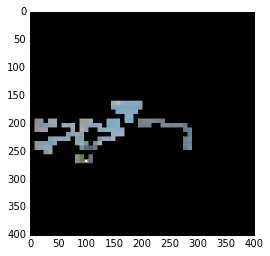

In [10]:
ratio = int(400/min([divh,divw]))
decolor_img = np.zeros((ratio*divh, ratio*divw, 3), np.uint8)
dr = int(ratio/3)
orbitimgs = []
for i in range(len(iwhs)):
    iw = np.array(iwhs)[i,0]
    ih = np.array(iwhs)[i,1]
    if(i>0):
        iwold = np.array(iwhs)[i-1,0]
        ihold = np.array(iwhs)[i-1,1]
        cv2.rectangle(decolor_img, (ratio*iwold, ratio*ihold), (ratio*(iwold+1)-1, ratio*(ihold+1)-1), codesRGBF[i-1], -1, 0)
    cv2.rectangle(decolor_img, (ratio*iw, ratio*ih), (ratio*(iw+1)-1, ratio*(ih+1)-1), codesRGBF[i], -1, 0)
    cv2.rectangle(decolor_img, (ratio*iw+dr, ratio*ih+dr), (ratio*(iw+1)-1-dr, ratio*(ih+1)-1-dr), np.array([255.,255.,255.]), -1, 0)
    cv2.imwrite("orbit_dc_melody/decolor-orbit"+str(i)+".jpg", cv2.cvtColor(decolor_img,cv2.COLOR_RGB2BGR) )
    orbitimgs.append( cv2.cvtColor(decolor_img,cv2.COLOR_RGB2BGR) )
plt.imshow(decolor_img)

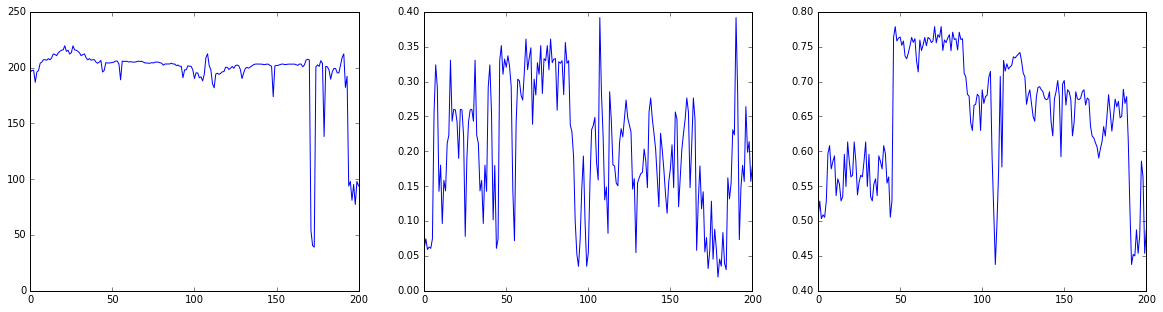

In [11]:
# print(codesHSVF)
Hs = codesHSVF[:,0]
Ss = codesHSVF[:,1]
Vs = codesHSVF[:,2]

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.plot(Hs)
ax2.plot(Ss)
ax3.plot(Vs)

### musicize

In [12]:
initial_octave = 3 #0=[C0, C#0, ..., C1]
initial_key = 0 # 0=C=ド
plus_octave = 2

T0old = 0
Tmin = 0
T0ratio = 3
Tratio = 3
bpm = 120
time1count = 60/bpm
time1loop = 8*time1count
time1loophalf = time1loop/2
dT0 = time1count/2
dT = time1count/2
#dT = Tbase/2
##dT = 0.2
#Tratio = 2.4

sr = 44100 # sampling rate ex.44100Hz

# t1: time of peak
# a1: trancation exponent(a1=1: NoEffect, 1<<a1: too tracate)
# a2: trancation exponent(0<a2, 0<a2<<1: too tracate, 1<<a2: NoEffect
# a1=-1&a2=1: convex trancation shape

start_time = time.time()
wave_temp = []
#lens = []
freqs = []
Ts = []
T0s = []
Hmin = min(Hs)
Hmax = max(Hs)
Smin = min(Ss)
Smax = max(Ss)
Vmin = min(Vs)
Vmax = max(Vs)
for i in range(len(Hs)):
    freq = value2keywb(initial_octave, plus_octave, initial_key, [Hs[i],Hmin,Hmax], [1, allwhites, allblacks])
    freqs.append(freq)
    Stld = (Ss[i]-Smin)/(Smax-Smin)
    Vtld = (Vs[i]-Vmin)/(Vmax-Vmin)
    if(i==0):
        T0 = 0
    elif(i>0):
        T0 = T0old + dT0*int(T0ratio*(1-Stld)+1)
    T0s.append(T0)
    T0old = T0

    if( i<(len(Hs)-1) ):
        T = Tmin + dT*int(Tratio*(1-Stld)+1)
    elif( i==(len(Hs)-1) ):
        for ii in range(2):
            if( ii*time1loophalf<T0<(ii+1)*time1loophalf ):
                dTlastratio=int(((ii+1)*time1loophalf-T0)/dT)
                print("hello", ii, dTlastratio)
                T = Tmin + dT*(int(dTlastratio*(1-Stld)+1))
    Ts.append(T)
    
    aparam = [0.02*T*Vtld, 1, 0.1*Vtld] #t1,a1,a2
#    aparam = [0.02*T, 1, 0.1] #t1,a1,a2
#    wave_temp0 = makeampFnwave(1, freq, T, dT, sr, aparam)
    wave_temp0 = makeampFnwave(1, freq, T, sr, aparam)
    
    bfr0 = int(T0*sr)
#    bfr0 = int(T0*100000)
    wave_temp0 = np.lib.pad(wave_temp0,(bfr0, 0),"constant",constant_values = 0)
    if(i==0):
        wave_temp1 = wave_temp0
    elif(i>0):
        wave_temp1 = merge1d(wave_temp0, wave_temp1)
        
wave0 = wave_temp1
wave_melody_base = wave0
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time, "sec   ", elapsed_time/60, "min   ", elapsed_time/3600, "hour")

49.834434032440186 sec    0.8305739005406697 min    0.013842898342344496 hour


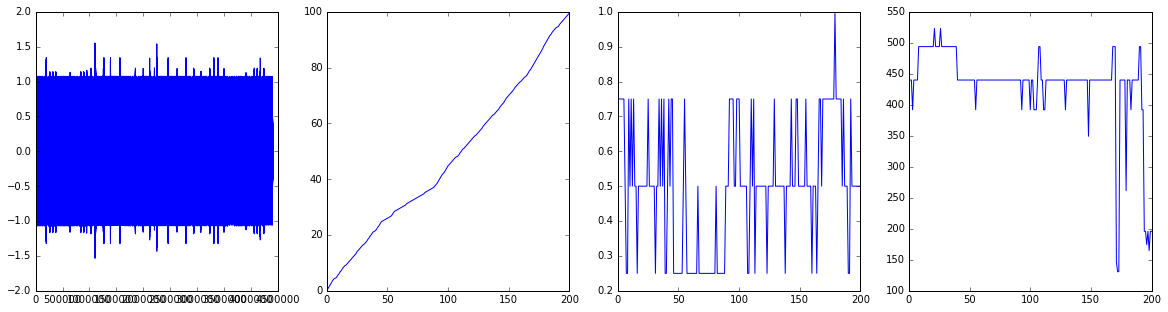

In [13]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

#C3:130.81, B3:246.94, C4:261.63, B4:493.88, C5:523,25
ax1.plot(wave0)
ax2.plot(T0s)
ax3.plot(Ts)
ax4.plot(freqs)

In [14]:
wave0max = max(abs(wave0))
print(wave0max)
wave0 = wave0/wave0max
wavwrite(wave0,"music_w"+str(divw)+"h"+str(divh)+".wav")

1.55268026352


In [15]:
wave_melody = wave0

## loop part --------------------------------------------------

In [ ]:
divw = 2
divh = 2
heights, widths, dividedimgs = divideimage(img, divw, divh)
#print(dividedimgs.shape)
#dividedimgs

In [ ]:
decolorRGBs = []
decolorHSVs = []
for iw in range(divw):
    tempRGB = []
    tempHSV = []
    for ih in range(divh):
#        meanRGB = mean_image(dividedimgs[ih,iw])
#        print(dividedimgs[ih][iw])
        meanRGB = mean_image(dividedimgs[ih][iw])
#        print(meanRGB)
        tempRGB.append( meanRGB )
        tempHSV.append( rgb2hsv(meanRGB[0],meanRGB[1],meanRGB[2]) )
    decolorRGBs.append(tempRGB)
    decolorHSVs.append(tempHSV)
decolorRGBs = np.array(decolorRGBs)
decolorHSVs = np.array(decolorHSVs)

print(decolorRGBs.shape)

In [ ]:
codesRGBF = []
codesHSVF = []
codes = []
icode = 0
iw = int(divw/2)
ih = int(divh/2)
codesRGBF.append( decolorRGBs[iw,ih] )
codesRGBF = np.array(codesRGBF)
#print(codesRGBF)

codesHSVF.append( decolorHSVs[iw,ih] )
codesHSVF = np.array(codesHSVF)
#print(codesHSVF)

#icode0 = 0
icodemax = 300
diw = 1
dih = 1
iwhssetall = []
icheckth = 1
for iih in range(divh):
    for iiw in range(divw):
        iwhssetall.append(str(iiw)+","+str(iih))
        
iwhsset = set([])
iwhs = []
ilogs = []
iwhs.append([iw,ih])
ilogs.append([0,9,iw,ih])
print("[icode, inextposition, iw,ih]", ilogs[0])
inextpositions = []
icheck = 0
#for ii in range(icodemax):
while (len(iwhsset) != len(iwhssetall)) and (icode < icodemax) :
    icode = icode + 1
                
    nextsRGBF = []
    nextsHSVF = []
    inextpositionBoundaries =[]
    iBoundaries = [0,0,0,0]
    if(iw+diw <= divw-1):
        nextsRGBF.append( decolorRGBs[iw+diw,ih] )
        nextsHSVF.append( decolorHSVs[iw+diw,ih] )
    else:
        if(iw < divw-1):
            nextsRGBF.append( decolorRGBs[divw-1,ih] )
            nextsHSVF.append( decolorHSVs[divw-1,ih] )
            iBoundaries[0] = 1
        else:
            nextsRGBF.append( np.array([random.random(),random.random(),random.random()]) )
            nextsHSVF.append( [random.random(),random.random(),random.random()] )
            inextpositionBoundaries.append(0)

    if(iw-diw >= 0):
        nextsRGBF.append( decolorRGBs[iw-diw,ih] )
        nextsHSVF.append( decolorHSVs[iw-diw,ih] )
    else:
        if(iw > 0):
            nextsRGBF.append( decolorRGBs[0,ih] )
            nextsHSVF.append( decolorHSVs[0,ih] )
            iBoundaries[1] = 1
        else:
            nextsRGBF.append( np.array([random.random(),random.random(),random.random()]) )
            inextpositionBoundaries.append(1)
            nextsHSVF.append( [random.random(),random.random(),random.random()] )

    if(ih+dih <= divh-1):
        nextsRGBF.append( decolorRGBs[iw,ih+dih] )
        nextsHSVF.append( decolorHSVs[iw,ih+dih] )
    else:
        if(ih < divh-1):
            nextsRGBF.append( decolorRGBs[iw,divh-1] )
            nextsHSVF.append( decolorHSVs[iw,divh-1] )
            iBoundaries[2] = 1
        else:
            nextsRGBF.append( np.array([random.random(),random.random(),random.random()]) )
            inextpositionBoundaries.append(2)
            nextsHSVF.append( [random.random(),random.random(),random.random()] )

    if(ih-dih >= 0):
        nextsRGBF.append( decolorRGBs[iw,ih-dih] )
        nextsHSVF.append( decolorHSVs[iw,ih-dih] )
    else:
        if(ih > 0):
            nextsRGBF.append( decolorRGBs[iw,0] )
            nextsHSVF.append( decolorHSVs[iw,0] )
            iBoundaries[3] = 1
        else:
            nextsRGBF.append( np.array([random.random(),random.random(),random.random()]) )
            inextpositionBoundaries.append(3)
            nextsHSVF.append( [random.random(),random.random(),random.random()] )
            #print("hello3c")

    nextsHSVF = np.array(nextsHSVF)
    nextsRGBF = np.array(nextsRGBF)

    nextsHF = nextsHSVF[:,0]
    dHues = abs( nextsHF - codesHSVF[icode-1,0] )
    
    dHuesSort = np.sort(dHues)
    dHuesSort

    dHuesindex = []
    for i in range(len(dHues)):
        dHuesindex.append( dHues.tolist().index(dHuesSort[i]) )

    dHuesindexbad = set([])
    if( icode > 1 ):
        if( inextpositionold != 9 ):
            dHuesindexbad.add( dHuesindex.index(inextpositionold) )
    if(len(inextpositionBoundaries) > 0):
        for i in range(len(inextpositionBoundaries)):
            if( icode > 1 ):
                if( inextpositionold != 9 ):
                    if( dHuesindex.index(inextpositionold) != dHuesindex.index(inextpositionBoundaries[i]) ):
                        dHuesindexbad.add( dHuesindex.index(inextpositionBoundaries[i]) )
    dHuesindexbad = list(dHuesindexbad)

    dHuesindexbad = sorted(dHuesindexbad, reverse=True)

    if( len(dHuesindexbad) > 0 ):
        for i in range( len(dHuesindexbad) ):
            dHuesindex.pop( dHuesindexbad[i] )

    inextposition = dHuesindex[0]   #close color
#    inextposition = dHuesindex[ len(dHuesindex)-1 ]   #different color
#    inextposition = dHuesindex[ random.randint(0,len(dHuesindex)-1) ]
    inextpositions.append(inextposition)

    codesRGBF = np.concatenate(np.array([codesRGBF, [nextsRGBF[inextposition]] ]))
    codesHSVF = np.concatenate(np.array([codesHSVF, [nextsHSVF[inextposition]] ]))

    if(inextposition == 0):
        if(iBoundaries[inextposition] == 1):
            iw = divw - 1
        else:
            iw = iw + diw
        inextpositionold = 1
            
    if(inextposition == 1):
        if(iBoundaries[inextposition] == 1):
            iw = 0
        else:
            iw = iw - diw
        inextpositionold = 0
    if(inextposition == 2):
        if(iBoundaries[inextposition] == 1):
            ih = divh - 1
        else:
            ih = ih + dih
        inextpositionold = 3
    if(inextposition == 3):
        if(iBoundaries[inextposition] == 1):
            ih = 0
        else:
            ih = ih - dih
        inextpositionold = 2
    if(np.mod(icode,1)==0):
#    if(icode>10):
        print("[icode, inextposition, iw,ih]", [icode, inextposition, iw,ih])
    iwhsset.add(str(iw)+","+str(ih))
    
    diw = 1
    dih = 1
    ilogscount = ilogs.count([inextposition,iw,ih])
    if( ilogscount > 0 ):
        dih = ilogscount + 1
        diw = ilogscount + 1
        deltaiwsort = sorted([abs(divw-iw)-1,iw])
        deltaihsort = sorted([abs(divh-ih)-1,ih])
        if( deltaiwsort[1] < diw ):
            diw = deltaiwsort[0]
            if( deltaiwsort[0] == 0 ):
                diw = deltaiwsort[0] + 1
        if( deltaihsort[1] < dih ):
            dih = deltaihsort[0]
            if( deltaihsort[0] == 0 ):
                dih = deltaihsort[0] + 1
        print("diw", diw, "   dih", dih)
        
        if( icheck < icheckth ):
            if( deltaiwsort[0] == 0 ):
                if( deltaihsort[0] == 0 ):
                    icheck += 1
        if( icheck == icheckth ):
            if( deltaiwsort[0] == 0 ):
                if( deltaihsort[0] == 0 ):
                    if(set(iwhssetall) != iwhsset):
                        iwhssetrem = set(iwhssetall).difference(iwhsset)
                        iwhsrem=",".join(iwhssetrem)
                        iwhsrem=iwhsrem.split(",")
                        iw = int(iwhsrem[0])
                        ih = int(iwhsrem[1])

                    if(set(iwhssetall) == iwhsset):
                        iw = np.array(iwhs)[0,0]
                        ih = np.array(iwhs)[0,1]
            
                    inextposition = 9
                    print("[icode, inextposition, iw,ih]", [icode, inextposition, iw,ih])
                    iwhsset.add(str(iw)+","+str(ih))
                    
                    icheck = 0

                    codesRGBF[icode] = decolorRGBs[iw,ih]
                    codesHSVF[icode] = decolorHSVs[iw,ih]
                    inextposition = 9

    iwhs.append([iw,ih])
    ilogs.append([inextposition,iw,ih])

In [ ]:
ratio = int(400/min([divh,divw]))
decolor_img = np.zeros((ratio*divh, ratio*divw, 3), np.uint8)
dr = int(ratio/3)
orbitimgs = []
for i in range(len(iwhs)):
    iw = np.array(iwhs)[i,0]
    ih = np.array(iwhs)[i,1]
    if(i>0):
        iwold = np.array(iwhs)[i-1,0]
        ihold = np.array(iwhs)[i-1,1]
        cv2.rectangle(decolor_img, (ratio*iwold, ratio*ihold), (ratio*(iwold+1)-1, ratio*(ihold+1)-1), codesRGBF[i-1], -1, 0)
    cv2.rectangle(decolor_img, (ratio*iw, ratio*ih), (ratio*(iw+1)-1, ratio*(ih+1)-1), codesRGBF[i], -1, 0)
    cv2.rectangle(decolor_img, (ratio*iw+dr, ratio*ih+dr), (ratio*(iw+1)-1-dr, ratio*(ih+1)-1-dr), np.array([255.,255.,255.]), -1, 0)
    cv2.imwrite("orbit_dc_loop/decolor-orbit"+str(i)+".jpg", cv2.cvtColor(decolor_img,cv2.COLOR_RGB2BGR) )
    orbitimgs.append( cv2.cvtColor(decolor_img,cv2.COLOR_RGB2BGR) )
plt.imshow(decolor_img)

In [ ]:
# print(codesHSVF)
Hs = codesHSVF[:,0]
Ss = codesHSVF[:,1]
Vs = codesHSVF[:,2]

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.plot(Hs)
ax2.plot(Ss)
ax3.plot(Vs)

### musicize

In [ ]:
initial_octave = 4 #0=[C0, C#0, ..., C1]
initial_key = 0 # 0=C=ド
plus_octave = 1

T0old = 0
Tmin = 0
T0ratio = 1
Tratio = 1
bpm = 120
time1count = 60/bpm
time1loop = 8*time1count
time1loophalf = time1loop/2
dT0 = time1count/2
dT = time1count/2
#dT = Tbase/2
##dT = 0.2
#Tratio = 2.4

sr = 44100 # sampling rate ex.44100Hz

# t1: time of peak
# a1: trancation exponent(a1=1: NoEffect, 1<<a1: too tracate)
# a2: trancation exponent(0<a2, 0<a2<<1: too tracate, 1<<a2: NoEffect
# a1=-1&a2=1: convex trancation shape

start_time = time.time()
wave_temp = []
#lens = []
freqs = []
Ts = []
T0s = []
Hmin = min(Hs)
Hmax = max(Hs)
Smin = min(Ss)
Smax = max(Ss)
Vmin = min(Vs)
Vmax = max(Vs)
for i in range(len(Hs)):
    freq = value2keywb(initial_octave, plus_octave, initial_key, [Hs[i],Hmin,Hmax], [1, allwhites, allblacks])
    freqs.append(freq)
    Stld = (Ss[i]-Smin)/(Smax-Smin)
    Vtld = (Vs[i]-Vmin)/(Vmax-Vmin)
    if(i==0):
        T0 = 0
    elif(i>0):
        T0 = T0old + dT0*int(T0ratio*(1-Stld)+1)
    T0s.append(T0)
    T0old = T0

    if( i<(len(Hs)-1) ):
        T = Tmin + dT*int(Tratio*(1-Stld)+1)
    elif( i==(len(Hs)-1) ):
        for ii in range(2):
            if( ii*time1loophalf<T0<(ii+1)*time1loophalf ):
                dTlastratio=int(((ii+1)*time1loophalf-T0)/dT)
                print("hello", ii, dTlastratio)
                T = Tmin + dT*(int(dTlastratio*(1-Stld)+1))
    Ts.append(T)
    
    aparam = [0.02*T*Vtld, 1, 0.1*Vtld] #t1,a1,a2
#    aparam = [0.02*T, 1, 0.1] #t1,a1,a2
#    wave_temp0 = makeampFnwave(1, freq, T, dT, sr, aparam)
    wave_temp0 = makeampFnwave(1, freq, T, sr, aparam)
    
    bfr0 = int(T0*sr)
#    bfr0 = int(T0*100000)
    wave_temp0 = np.lib.pad(wave_temp0,(bfr0, 0),"constant",constant_values = 0)
    if(i==0):
        wave_temp1 = wave_temp0
    elif(i>0):
        wave_temp1 = merge1d(wave_temp0, wave_temp1)
        
wave0 = wave_temp1
wave_loop_base = wave0
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time, "sec   ", elapsed_time/60, "min   ", elapsed_time/3600, "hour")

In [ ]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

#C3:130.81, B3:246.94, C4:261.63, B4:493.88, C5:523,25
ax1.plot(wave0)
ax2.plot(T0s)
ax3.plot(Ts)
ax4.plot(freqs)

In [ ]:
wave0max = max(abs(wave0))
print(wave0max)
wave0 = wave0/wave0max
wave0 = list(wave0)
wave0 = wave0 + wave0 + wave0 + wave0 + wave0 + wave0 + wave0 + wave0 + wave0 + wave0
wave0 = wave0 + wave0 + wave0 + wave0 + wave0 + wave0
wavwrite(wave0,"music_w"+str(divw)+"h"+str(divh)+".wav")

In [ ]:
wave_loop = wave0

## Mix melody and loop ---------------------------------------

In [ ]:
wave0 = merge1d(wave_melody, wave_loop)

In [ ]:
wave0max = max(abs(wave0))
print(wave0max)
wave0 = wave0/wave0max
wavwrite(wave0,"music_mix.wav")

In [ ]:
end_whole_time = time.time()
elapsed_whole_time = end_whole_time - start_whole_time
print(elapsed_whole_time, "sec   ", elapsed_whole_time/60, "min   ", elapsed_whole_time/3600, "hour")